# Smoker Status Challenge

The goal is obtain the max accuracy evaluating the test database. The train database will be used for model fitting

#### The steps are:

- Explore
- Transform
- Cleanse
- Enrich
- Train
- Run
- Test

Before start we'll import the default tools and import the datasets

In [71]:
import pandas as pd
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

random.seed(1)

train = pd.read_csv('./train 2.csv')

## Explore

Based on train data we'll explore each column and test the correlation between the result

   id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0   55         165          60       81.0             0.5   
1   1   70         165          65       89.0             0.6   
2   2   20         170          75       81.0             0.4   
3   3   35         180          95      105.0             1.5   
4   4   30         165          60       80.5             1.5   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...  HDL  LDL  \
0              0.6              1               1       135  ...   40   75   
1              0.7              2               2       146  ...   57  126   
2              0.5              1               1       118  ...   45   93   
3              1.2              1               1       131  ...   38  102   
4              1.0              1               1       121  ...   44   93   

   hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  \
0        16.5              1               1.0   22   25   2

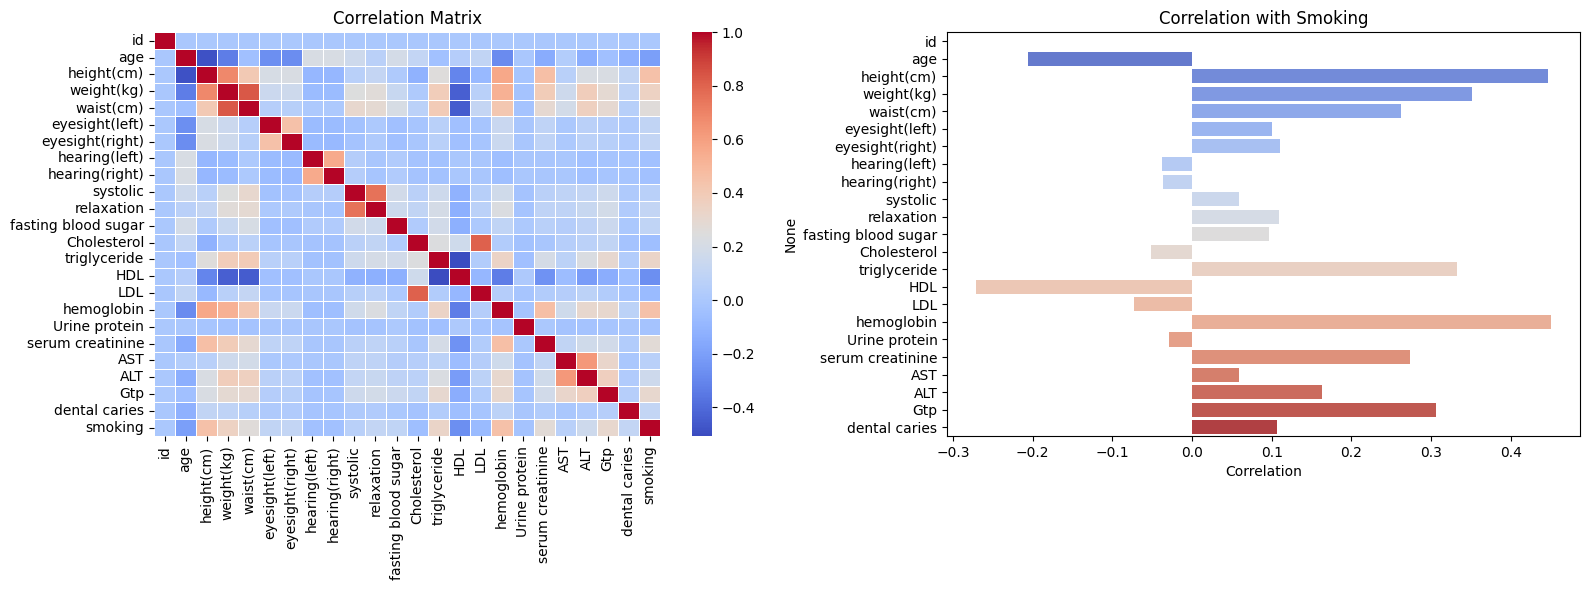

In [72]:
from seaborn import heatmap
from seaborn import barplot

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

correlation_matrix = train.corr()

heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=.5, ax=axes[0])
axes[0].set_title("Correlation Matrix")

correlation_with_smoking = train.corr()["smoking"].drop("smoking")

barplot(x=correlation_with_smoking.values, y=correlation_with_smoking.index, palette="coolwarm", hue=correlation_with_smoking.index, legend=False, ax=axes[1])
axes[1].set_xlabel("Correlation")
axes[1].set_title("Correlation with Smoking")

plt.tight_layout()

print(train.head())
plt.show()

<Axes: xlabel='age category', ylabel='smoking'>

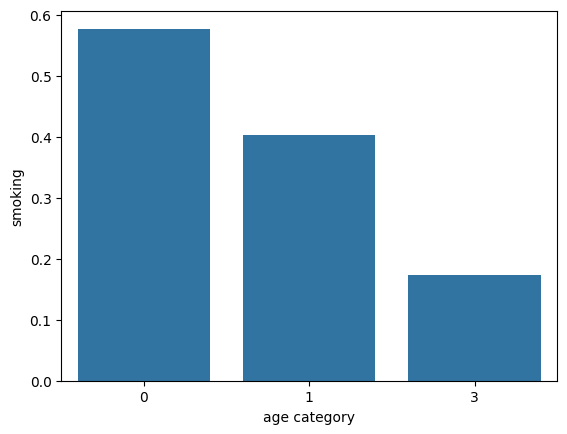

In [73]:
age_categories = pd.cut(train['age'], bins=[19, 38, 65, 200],
                labels=[0, 1, 3])

age_categories_comparison = pd.DataFrame()
age_categories_comparison['smoking'] = train['smoking']
age_categories_comparison['age category'] = age_categories

dataset = age_categories_comparison.groupby('age category', observed=False).mean()
barplot(x='age category', y='smoking', data=dataset)

### Initially, it indicates that the (20 - 38) years group has more change to be smoker, with more than 55% of chance. The second group (39 - 65 years) has at least 40% of chance.

0         0
1         0
2         0
3         0
4         0
         ..
159251    0
159252    0
159253    0
159254    0
159255    0
Length: 159256, dtype: category
Categories (3, int64): [0 < 1 < 2]
count     159256
unique         3
top            0
freq      159251
Name: LDL, dtype: int64


<Axes: xlabel='LDL', ylabel='smoking'>

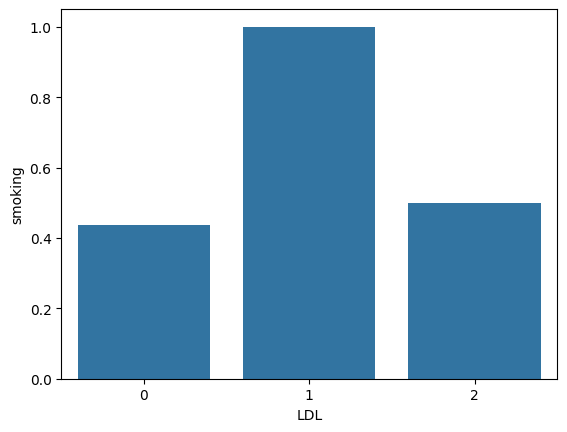

In [75]:
ast_alt_categories = pd.cut(train['AST']*train['ALT'], bins=3, labels=[0,1,2])
print(ast_alt_categories)

ast_alt_comparison = pd.DataFrame()
ast_alt_comparison['smoking'] = train['smoking']
ast_alt_comparison['LDL'] = ast_alt_categories

dataset = ast_alt_comparison.groupby('LDL', observed=False).mean()
print(ast_alt_comparison['LDL'].describe())
barplot(x='LDL', y='smoking', data=dataset)

## Transform

Nothing to do right now

## Enrich
Now we'll include the good exploration results into our train dataset!

In [76]:
def enrich(df):
    df['bmi'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
    df['hw_ratio'] = df['height(cm)'] / df['waist(cm)']
    df['ha_ratio'] = df['height(cm)'] / df['age']
    df['ast_alt_status'] = df['AST']*df['ALT']
    df['age_categories'] = age_categories


enrich(train)

## Cleanse

It's time to remove unused columns!

In [77]:
def cleanse(df):
    df.drop(['id','AST', 'ALT','weight(kg)','waist(cm)', 'hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries'], axis=1, inplace=True)

cleanse(train)

## Train

It's time to train our model!!

In [78]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

train.dropna(inplace=True)

x = train.drop(['smoking'], axis=1)
y = train['smoking']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, stratify=y)

model = XGBClassifier()

# Define the hyperparameters grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x, train_y)

# Get the best parameters
best_params = grid_search.best_params_

model = XGBClassifier(**best_params)

model.fit(train_x, train_y)

predictions = model.predict(test_x)

score = accuracy_score(predictions, test_y)*100

print(score)

78.12829657909278


[0.01457572 0.55319613 0.00574199 0.00540415 0.00753742 0.00764854
 0.00665833 0.01100872 0.04262973 0.00977021 0.02179918 0.14630869
 0.02694557 0.079554   0.01429331 0.0057371  0.02234787 0.0188434 ]
Index(['age', 'height(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'Gtp', 'BMI',
       'HW_Ratio', 'HA_Ratio', 'ast-alt-status'],
      dtype='object')


<Axes: xlabel='importances', ylabel='column'>

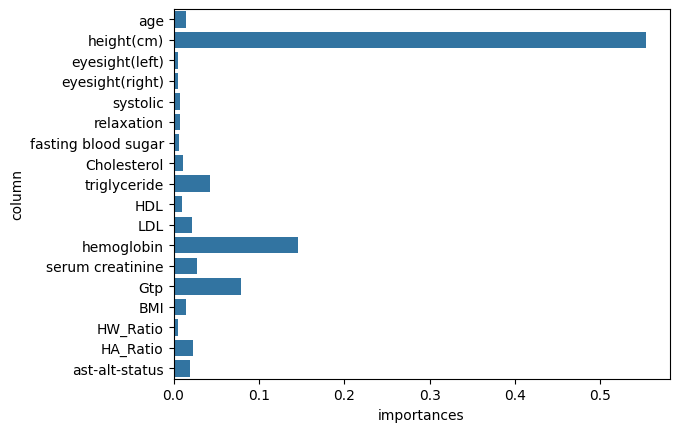

In [79]:

print(model.feature_importances_)
print(x.columns)

result = pd.DataFrame()
result['column'] = x.columns
result['importances'] = model.feature_importances_

barplot(data=result, x='importances', y='column')

## Test
Now, we'll prepare and submit our dataset to Kaggle challenge

In [80]:
final_result = pd.DataFrame()

test = pd.read_csv('./test 2.csv')

final_result['id'] = test['id']

enrich(test)
cleanse(test)

test_predictions = model.predict(test)

final_result['smoking'] = test_predictions

final_result.to_csv('./result.csv', index=False)

print(final_result)

            id  smoking
0       159256        1
1       159257        0
2       159258        0
3       159259        0
4       159260        1
...        ...      ...
106166  265422        1
106167  265423        1
106168  265424        0
106169  265425        0
106170  265426        0

[106171 rows x 2 columns]
